In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, AgglomerativeClustering, OPTICS, DBSCAN, cluster_optics_dbscan
from sklearn_extra.cluster import KMedoids
import random
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from sklearn.base import clone
import yfinance as yf
from utils.utils import Portfolio
from utils.helpers import pooled_within_ssd, gen_realizations, gap_statistic, cluster_range, plot_internal, plot_internal_zoom_range, generate_date_combinations, calcCorr, correlDist
from utils.clusters import kmeans_cluster, kmedoids_cluster, agglomerative_cluster
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers = 6)
from tqdm import tqdm
tqdm.pandas()

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Load Data from YF for S&P500 and save it

In [4]:
sp500 = Portfolio('2013-01-01', '2024-01-01')
dji = Portfolio('2012-01-01','2024-01-01', file = 'data/dji.csv')
gspc = Portfolio('2012-01-01','2024-01-01', file = 'data/gspc.csv')

## Baselines for Sharpe Ratio: DJI & 30 Random

In [5]:
def create_port(row, ticker = None, file = 'data/sp500_data.csv'):
    buy_date = row['Buy']
    sell_date = row['Sell']
    port = Portfolio(buy_date, sell_date, file = file)
    
    if not ticker:
        tickers = port.prices.columns

    sharpe = port.get_portf_sharpe(tick = ticker)
    sortino = port.get_portf_sortino(tick = ticker)
    returns = port.get_portf_return(tick = ticker)

    return pd.Series([sharpe, sortino, returns])

def random_port(row, k = 30, trials = 100, file = 'data/sp500_data.csv'):
    
    results = pd.DataFrame(columns = ['Sharpe', 'Sortino', 'Return'])
    
    buy_date = row['Buy']
    sell_date = row['Sell']
    port = Portfolio(buy_date, sell_date, file = file)

    for i in range(trials):
        ticker = random.sample(list(port.daily_log_returns.columns), k)
        sharpe = port.get_portf_sharpe(tick = ticker)
        sortino = port.get_portf_sortino(tick = ticker)
        returns = port.get_portf_return(tick = ticker)
        results.loc[i] = [sharpe, sortino, returns]

    return pd.Series(results.mean().tolist())

In [6]:
baseline5 = pd.read_csv('data/baseline_5-1.csv').drop(['Unnamed: 0'], axis = 1)
baseline7 = pd.read_csv('data/baseline_7-1.csv').drop(['Unnamed: 0'], axis = 1)
baseline3 = pd.read_csv('data/baseline_3-1.csv').drop(['Unnamed: 0'], axis = 1)

To set the baselines, we are using the Dow Jones Index which is a stock market index that measures the stock performance of 30 prominent companies listed on stock exchanges in the United States. We also used the average of a 30-trial Monte Carlo Simulation of 30 random stock portfolios.

### KMeans: K clusters

In [7]:
def kmeans_port_corr(row, k = 30, scale = False):
    start_date = row['Start']
    end_date = row['End']
    buy_date = row['Buy']
    sell_date = row['Sell']
    
    port_train = Portfolio(start_date, end_date)
    X = port_train.daily_log_returns
    corrmat = calcCorr(X)
    D = correlDist(corrmat)
    tickers = list(X.columns)
    port_test = Portfolio(buy_date, sell_date, tickers = tickers)
    results = kmeans_cluster(D, port_train.stock_sharpe, port_test, k = 30, scale = scale, verbose = False, cluster_metrics = True, compare = dji)
    
    return pd.Series(list(results.values()))

In [10]:
seed_train = Portfolio('2013-01-01', '2022-12-31')
seed_test = Portfolio('2023-01-01', '2023-12-31')
seed_corrmat = calcCorr(seed_train.daily_log_returns)
seed_D = correlDist(seed_corrmat)
results = kmeans_cluster(seed_D, seed_train.stock_sharpe, seed_test, cluster_metrics = True, compare = dji)
results

Clustering Type        : KMeans
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1178
Silhouette Score       : 0.1875
Davies-Bouldin         : 1.5802
Calinski Harabasz      : 68.3492


{'portfolio': ['ODFL',
  'TT',
  'SMCI',
  'NEE',
  'DHR',
  'VLO',
  'TDG',
  'MAA',
  'AVGO',
  'CHD',
  'LLY',
  'ORLY',
  'WM',
  'GD',
  'DE',
  'DECK',
  'LYV',
  'GL',
  'CTAS',
  'PGR',
  'IEX',
  'KR',
  'EXR',
  'DPZ',
  'MSCI',
  'HCA',
  'KDP',
  'UNH',
  'JNJ',
  'WRB'],
 'sharpe': 0.1177715574631479,
 'sortino': 0.1688507763796592,
 'return': 0.2652775136826259,
 'silhouette': 0.18752014849629475,
 'db': 1.5802022597549907,
 'ch': 68.34921009578329,
 'min_mult': 0.4219672593159847,
 'p25_mult': 1.4609859228807578,
 'p50_mult': 2.205662761135849,
 'p75_mult': 4.289411258368911,
 'max_mult': 363.6406599656706,
 'mean_mult': 9.990255632635783,
 'min_preturn': 0.00032609127522557847,
 'p25_preturn': 0.056310528863895454,
 'p50_preturn': 0.08422813060619068,
 'p75_preturn': 0.12893124515524493,
 'max_preturn': 0.23185948447425497,
 'mean_preturn': 0.0942941286308529}

In [11]:
kmeans_corrdist = baseline5.copy()
kmeans_corrdist['scaled'] = False
kmeans_corrdist['metric'] = ''
kmeans_corrdist[list(results.keys())] = kmeans_corrdist.progress_apply(kmeans_port_corr, args = (30, False, ), axis = 1)
kmeans_corrdist['k'] = kmeans_corrdist['portfolio'].apply(lambda x: len(x))
kmeans_corrdist.to_csv('data/kmeans_corrrdist_5-1.csv', index = False)
kmeans_corrdist

 71%|███████   | 894/1258 [1:27:05<36:12,  5.97s/it]  /opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 92%|█████████▏| 1160/1258 [1:53:03<09:02,  5.53s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 1258/1258 [2:02:23<00:00,  5.84s/it]


,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,...,p75_mult,max_mult,mean_mult,min_preturn,p25_preturn,p50_preturn,p75_preturn,max_preturn,mean_preturn,k
0,2013-01-02,2018-01-02,2018-01-03,2019-01-03,-0.032721,-0.040314,-0.089736,-0.037119,-0.046407,-0.091616,...,1.225275,453.148568,3.398165,-0.125248,0.001598,0.023264,0.041865,0.073586,0.021088,30
1,2013-01-03,2018-01-03,2018-01-04,2019-01-04,-0.023208,-0.029039,-0.065482,-0.025641,-0.032619,-0.065310,...,1.324672,105.392746,1.683108,-0.126796,-0.006530,0.017502,0.039221,0.071686,0.016605,30
2,2013-01-04,2018-01-04,2018-01-05,2019-01-07,-0.024801,-0.031004,-0.069755,-0.025046,-0.031877,-0.063873,...,1.065518,163.322061,1.453942,-0.133329,-0.016013,0.005854,0.030693,0.063668,0.006160,30
3,2013-01-07,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,-0.021600,-0.027547,-0.055441,...,0.913176,23.737035,-1.917609,-0.138971,-0.016513,0.005184,0.025131,0.056744,0.003881,30
4,2013-01-08,2018-01-08,2018-01-09,2019-01-09,-0.020949,-0.026218,-0.059351,-0.021600,-0.027547,-0.055441,...,0.913176,23.737035,-1.917609,-0.138971,-0.016513,0.005184,0.025131,0.056744,0.003881,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253,2017-12-21,2022-12-21,2022-12-22,2023-12-22,0.068261,0.111013,0.131965,0.093912,0.148309,0.225079,...,3.477986,154.332608,6.598856,0.003451,0.058071,0.085026,0.129718,0.225963,0.093974,30
1254,2017-12-22,2022-12-22,2022-12-23,2023-12-26,0.067694,0.110051,0.130750,0.093920,0.148322,0.225101,...,4.649074,36.708284,4.353263,-0.001860,0.052864,0.079715,0.124611,0.224874,0.088804,30
1255,2017-12-26,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,...,3.090284,146.726344,4.892951,0.009342,0.064710,0.092077,0.138240,0.241424,0.102141,30
1256,2017-12-27,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,...,3.090284,146.726344,4.892951,0.009342,0.064710,0.092077,0.138240,0.241424,0.102141,30


In [12]:
kmeans_corrdist = baseline3.copy()
kmeans_corrdist['scaled'] = False
kmeans_corrdist['metric'] = ''
kmeans_corrdist[list(results.keys())] = kmeans_corrdist.progress_apply(kmeans_port_corr, args = (30, False, ), axis = 1)
kmeans_corrdist['k'] = kmeans_corrdist['portfolio'].apply(lambda x: len(x))
kmeans_corrdist.to_csv('data/kmeans_corrrdist_3-1.csv', index = False)
kmeans_corrdist

  8%|▊         | 134/1760 [12:04<2:31:18,  5.58s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 55%|█████▌    | 972/1760 [1:28:45<1:20:24,  6.12s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 79%|███████▉  | 1398/1760 [2:10:15<32:24,  5.37s/it]  /opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 94%|█████████▍| 1654/1760 [2:35:06<10:02,  5.69s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
 94%|█████████▍| 1663/1760 [2:36:01<09:56,  6.15s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountere

,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,...,p75_mult,max_mult,mean_mult,min_preturn,p25_preturn,p50_preturn,p75_preturn,max_preturn,mean_preturn,k
0,2013-01-02,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,...,0.575912,17.256695,0.447998,-0.076976,0.039608,0.076219,0.108177,0.155389,0.068719,30
1,2013-01-03,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,...,0.575912,17.256695,0.447998,-0.076976,0.039608,0.076219,0.108177,0.155389,0.068719,30
2,2013-01-04,2016-01-04,2016-01-05,2017-01-05,0.074345,0.096797,0.159723,0.066848,0.086858,0.157552,...,0.575912,17.256695,0.447998,-0.076976,0.039608,0.076219,0.108177,0.155389,0.068719,30
3,2013-01-07,2016-01-07,2016-01-08,2017-01-09,0.101586,0.134732,0.216618,0.090393,0.117972,0.212879,...,0.287790,0.567386,0.034362,-0.033101,0.091656,0.130674,0.161338,0.210309,0.122768,30
4,2013-01-08,2016-01-08,2016-01-11,2017-01-11,0.101416,0.134687,0.216830,0.093167,0.121049,0.220557,...,0.352423,9.413228,0.229412,-0.031553,0.090566,0.131109,0.163957,0.220133,0.122202,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,2019-12-20,2022-12-20,2022-12-21,2023-12-21,0.062459,0.102200,0.120680,0.086849,0.137748,0.207407,...,5.116671,1106.966371,10.339614,-0.008578,0.045482,0.071994,0.115010,0.211221,0.080149,30
1756,2019-12-23,2022-12-23,2022-12-27,2023-12-27,0.068684,0.111685,0.132814,0.094707,0.149568,0.227193,...,4.917521,66.818203,4.707525,-0.002295,0.052354,0.079295,0.123828,0.226492,0.088520,30
1757,2019-12-24,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,...,3.077546,146.483534,4.876448,0.009389,0.064679,0.092174,0.137503,0.241301,0.101826,30
1758,2019-12-26,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,...,3.077546,146.483534,4.876448,0.009389,0.064679,0.092174,0.137503,0.241301,0.101826,30


In [13]:
kmeans_corrdist = baseline7.copy()
kmeans_corrdist['scaled'] = False
kmeans_corrdist['metric'] = ''
kmeans_corrdist[list(results.keys())] = kmeans_corrdist.progress_apply(kmeans_port_corr, args = (30, False, ), axis = 1)
kmeans_corrdist['k'] = kmeans_corrdist['portfolio'].apply(lambda x: len(x))
kmeans_corrdist.to_csv('data/kmeans_corrrdist_7-1.csv', index = False)
kmeans_corrdist

 86%|████████▌ | 648/753 [1:04:45<10:38,  6.08s/it]/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
100%|██████████| 753/753 [1:15:32<00:00,  6.02s/it]


,Start,End,Buy,Sell,DJI_Sharpe,DJI_Sortino,DJI_Return,SP500_Sharpe,SP500_Sortino,SP500_Return,...,p75_mult,max_mult,mean_mult,min_preturn,p25_preturn,p50_preturn,p75_preturn,max_preturn,mean_preturn,k
0,2013-01-02,2020-01-02,2020-01-03,2021-01-04,0.009168,0.010150,0.055492,0.028635,0.030652,0.177011,...,2.544627,209.731138,4.200836,-0.331519,-0.055798,0.022332,0.068195,0.187544,0.002805,30
1,2013-01-03,2020-01-03,2020-01-06,2021-01-06,0.012096,0.013375,0.074069,0.031835,0.034036,0.199243,...,2.504618,125.466489,3.061844,-0.332313,-0.056104,0.022013,0.069524,0.191125,0.003053,30
2,2013-01-04,2020-01-06,2020-01-07,2021-01-07,0.013961,0.015390,0.085974,0.034209,0.036510,0.215735,...,2.330847,867.277854,6.501499,-0.331781,-0.056168,0.024851,0.071689,0.207011,0.004663,30
3,2013-01-07,2020-01-07,2020-01-08,2021-01-08,0.013319,0.014681,0.081853,0.034226,0.036529,0.215854,...,2.543950,44.572853,2.504573,-0.334285,-0.058892,0.021011,0.068427,0.206722,0.001729,30
4,2013-01-08,2020-01-08,2020-01-09,2021-01-11,0.011591,0.012811,0.070857,0.032841,0.035148,0.206262,...,2.608655,25.116443,2.208508,-0.337966,-0.063692,0.015549,0.063473,0.200049,-0.003017,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,2015-12-21,2022-12-21,2022-12-22,2023-12-22,0.068261,0.111013,0.131965,0.093912,0.148309,0.225079,...,3.463688,153.647238,6.571341,0.003369,0.057903,0.084855,0.129331,0.225682,0.093736,30
749,2015-12-22,2022-12-22,2022-12-23,2023-12-26,0.067694,0.110051,0.130750,0.093920,0.148322,0.225101,...,4.638991,36.642523,4.337910,-0.001820,0.052684,0.079562,0.124250,0.224593,0.088585,30
750,2015-12-23,2022-12-23,2022-12-27,2023-12-27,0.068684,0.111685,0.132814,0.094707,0.149568,0.227193,...,4.918067,66.638234,4.714982,-0.002274,0.052234,0.079261,0.124359,0.226312,0.088643,30
751,2015-12-24,2022-12-27,2022-12-28,2023-12-28,0.075951,0.123101,0.147051,0.100681,0.158315,0.242006,...,3.078425,146.432764,4.877041,0.009384,0.064557,0.092063,0.137934,0.241106,0.101919,30


## Preprocessing

### Scale Data: Standardization

In [41]:
standard_scaler = StandardScaler()
X_unscaled = sp500_train.daily_log_returns.T.copy()
X_scaled = standard_scaler.fit_transform(X_unscaled)

### Get correlation matrix

In [10]:
sp500_train.daily_log_returns.shape

(2517, 454)

In [16]:
corrmat = calcCorr(sp500_train.daily_log_returns)
D = correlDist(corrmat)
D.head()

,A,AAL,AAPL,ABBV,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA
A,0.000000,6.728647e-01,0.518100,0.597461,0.401841,0.575878,0.402839,0.448314,0.436219,0.605408,...,0.467517,0.538216,0.513753,0.642917,0.692124,0.637269,0.444616,0.583209,0.537552,0.509532
AAL,0.672865,2.220446e-16,0.713191,0.806432,0.749153,0.600648,0.648626,0.736530,0.631584,0.657266,...,0.858243,0.669855,0.564573,0.559275,0.890222,0.646929,0.589134,0.649453,0.609917,0.691774
AAPL,0.518100,7.131914e-01,0.000000,0.714444,0.548779,0.649359,0.468944,0.444080,0.444005,0.674649,...,0.602407,0.604007,0.569978,0.661918,0.709006,0.684302,0.576408,0.630626,0.627803,0.543051
ABBV,0.597461,8.064322e-01,0.714444,0.000000,0.547460,0.705927,0.620912,0.675080,0.670069,0.686535,...,0.680840,0.690775,0.681088,0.765044,0.741764,0.691626,0.673373,0.720196,0.627193,0.723029
ABT,0.401841,7.491526e-01,0.548779,0.547460,0.000000,0.593907,0.433422,0.506851,0.530174,0.618736,...,0.469841,0.548597,0.550590,0.749632,0.590836,0.700584,0.528507,0.602948,0.525018,0.592926


## Representative-Based Clustering (RBC): KMeans & KMedoids

### KMeans for 30 Clusters
For comparison to the DJI, we set our preset our cluster to 30 and pick the best performing stock in each cluster based on Sharpe ratio from 2013 to 2023. Each clsuter is supposed to represent differing levels of returns. We are diversifying our portfolio by taking one from each.



In [17]:
baseline.loc['Kmeans_30_corrdist'] = kmeans_cluster(D, sp500_train.stock_sharpe, sp500_test)
baseline

Clustering Type        : KMeans
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1178
Silhouette Score       : 0.1875
Davies-Bouldin         : 1.5802
Calinski Harabasz      : 68.3492


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278


### KMeans: Find optimal k-clusters

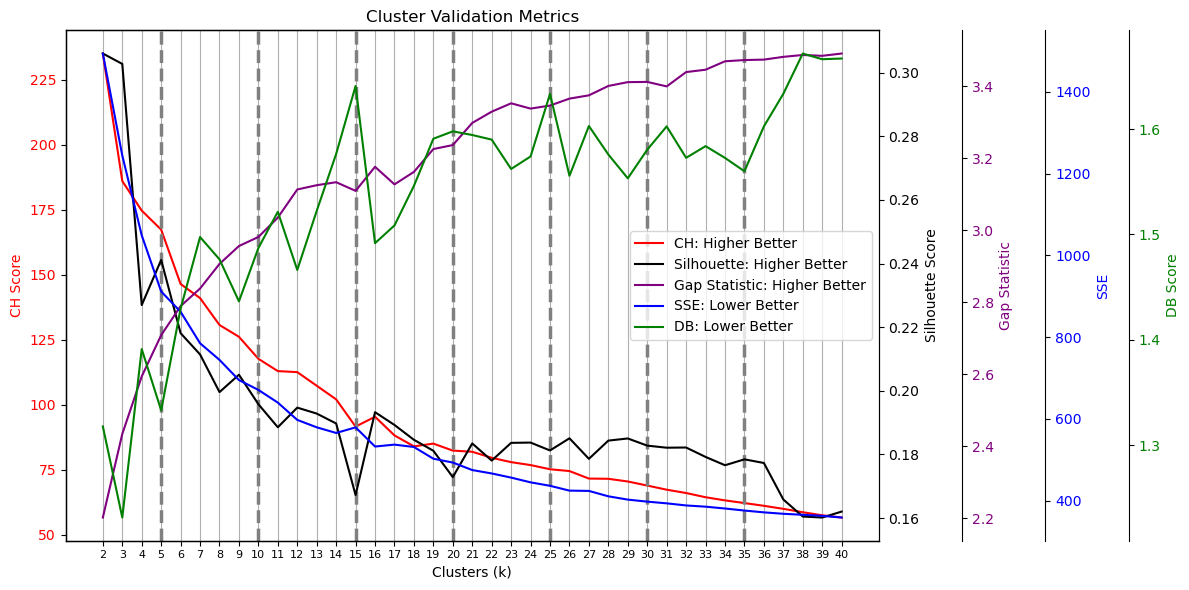

In [19]:
results = cluster_range(D.to_numpy(), KMeans(random_state=1234, n_init="auto"), 2, 40)
plot_internal_zoom_range(2, 40, results)

While we see that k = 2 is the highest silhouette score, we want to explore more specific clusters that could challenge the DJI (30 stocks). Hence we look at clusters ideally around 20 or more. Based on this plot, k=20 could be a good candidate due to having the next best silhouette score at k >= 20.


In [20]:
baseline.loc['Kmeans_26_corrdist'] = kmeans_cluster(D, sp500_train.stock_sharpe, sp500_test, k = 26)
baseline.loc['Kmeans_2_corrdist'] = kmeans_cluster(D, sp500_train.stock_sharpe, sp500_test, k = 2, top = 15)
baseline

Clustering Type        : KMeans
Clusters (preset)      : 26
Portfolio Sharpe Ratio : 0.1321
Silhouette Score       : 0.1802
Davies-Bouldin         : 1.5505
Calinski Harabasz      : 75.2627
Clustering Type        : KMeans
Clusters (preset)      : 2
Portfolio Sharpe Ratio : 0.0997
Silhouette Score       : 0.3059
Davies-Bouldin         : 1.3197
Calinski Harabasz      : 235.1648


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255


### KMEdoids for 30 Clusters


In [21]:
baseline.loc['Kmedoids_30_corrdist'] = kmedoids_cluster(D, sp500_train.stock_sharpe, sp500_test)
baseline

Clustering Type        : KMedoids
Clusters (preset)      : 30
Portfolio Sharpe Ratio : 0.1059
Silhouette Score       : 0.1794
Davies-Bouldin         : 1.5441
Calinski Harabasz      : 67.8823


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255
Kmedoids_30_corrdist,0.105904,0.159607,0.244279


### KMedoids: Find optimal k-clusters

Search for best k (# of clusters) Unscaled Train: k=24 (0.130), k=35 (0.138)

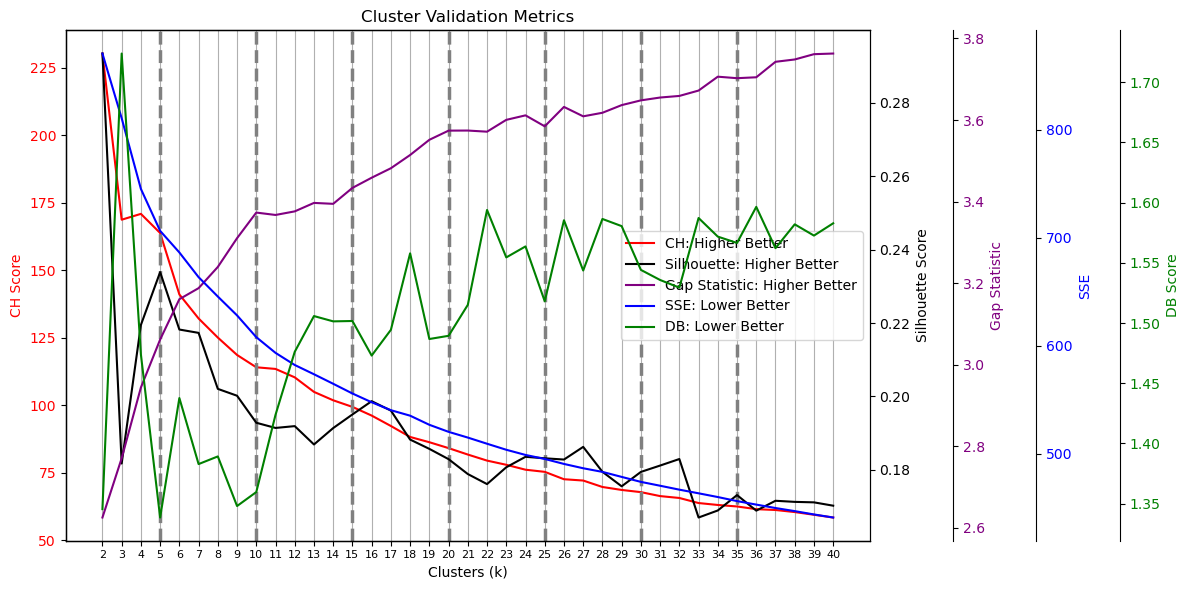

In [22]:
results = cluster_range(D.to_numpy(), KMedoids (random_state=1234, method="pam"), 2, 40)
plot_internal_zoom_range(2, 40, results)

In [23]:
baseline.loc['Kmedoids_27_corrdist'] = kmedoids_cluster(D, sp500_train.stock_sharpe, sp500_test, k = 27)
baseline.loc['Kmedoids_2_corrdist'] = kmedoids_cluster(D, sp500_train.stock_sharpe, sp500_test, k = 2, top = 15)
baseline

Clustering Type        : KMedoids
Clusters (preset)      : 27
Portfolio Sharpe Ratio : 0.0814
Silhouette Score       : 0.1863
Davies-Bouldin         : 1.5436
Calinski Harabasz      : 72.1734
Clustering Type        : KMedoids
Clusters (preset)      : 2
Portfolio Sharpe Ratio : 0.1226
Silhouette Score       : 0.2935
Davies-Bouldin         : 1.3454
Calinski Harabasz      : 230.2680


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255
Kmedoids_30_corrdist,0.105904,0.159607,0.244279
Kmedoids_27_corrdist,0.081372,0.122389,0.188329
Kmedoids_2_corrdist,0.122589,0.190844,0.264911


## Hierarchical Clustering: Agglomerative (Get 30 clusters)

In [37]:
baseline.loc['Agg_Single_30_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'single')
baseline.loc['Agg_Avg_30_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'average')
baseline.loc['Agg_Comp_30_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'complete')
baseline.loc['Agg_Ward_30_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'ward')
baseline.loc['Agg_Single_30_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'single', metric = 'precomputed')
baseline.loc['Agg_Avg_30_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'average', metric = 'precomputed')
baseline.loc['Agg_Comp_30_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'complete', metric = 'precomputed')
baseline

Linkage Method            : single
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.0681
Silhouette Score          : -0.1895
Davies-Bouldin            : 0.8425
Calinski Harabasz         : 5.8042


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Linkage Method            : average
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1276
Silhouette Score          : 0.1723
Davies-Bouldin            : 1.2750
Calinski Harabasz         : 59.5101


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Linkage Method            : complete
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1126
Silhouette Score          : 0.1636
Davies-Bouldin            : 1.5081
Calinski Harabasz         : 64.8312


/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Linkage Method            : ward
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1140
Silhouette Score          : 0.1732
Davies-Bouldin            : 1.4831
Calinski Harabasz         : 67.6164
Linkage Method            : single
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.0791
Silhouette Score          : -0.1251
Davies-Bouldin            : 0.7241
Calinski Harabasz         : 2.5621
Linkage Method            : average
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.0920
Silhouette Score          : 0.0341
Davies-Bouldin            : 1.0522
Calinski Harabasz         : 10.5434
Linkage Method            : complete
Preset Clusters           : 30
Sharpe Ratio of Portfolio : 0.1076
Silhouette Score          : 0.0458
Davies-Bouldin            : 1.9044
Calinski Harabasz         : 26.1030


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255
Kmedoids_30_corrdist,0.105904,0.159607,0.244279
Kmedoids_27_corrdist,0.081372,0.122389,0.188329
Kmedoids_2_corrdist,0.122589,0.190844,0.264911


## Hierarchical Clustering: Agglomerative (Get Optimal K clusters)

---



### Unscaled

In [38]:
from sklearn.cluster import AgglomerativeClustering

def agglomerative_clustering(data, linkage):
    model = AgglomerativeClustering(linkage=linkage)
    labels = model.fit_predict(data)
    silhouette_avg = silhouette_score(data, labels)
    return labels, silhouette_avg

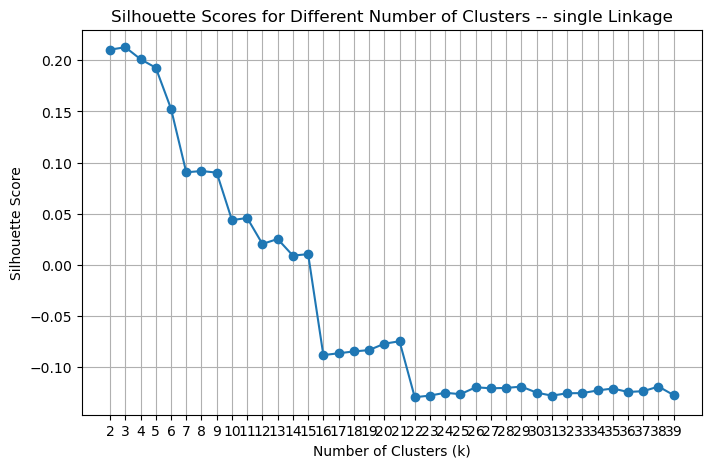

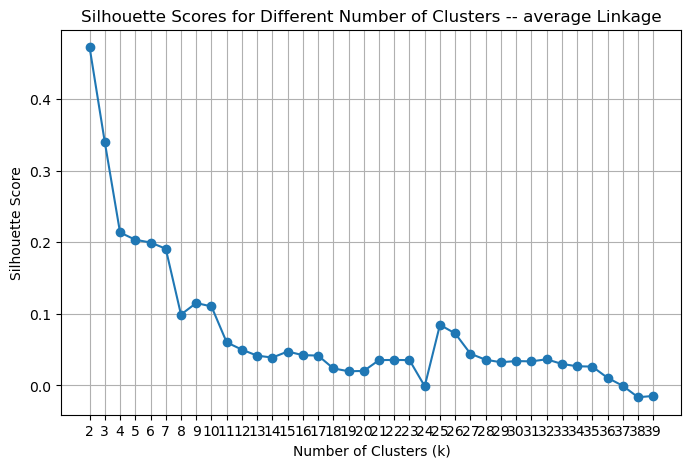

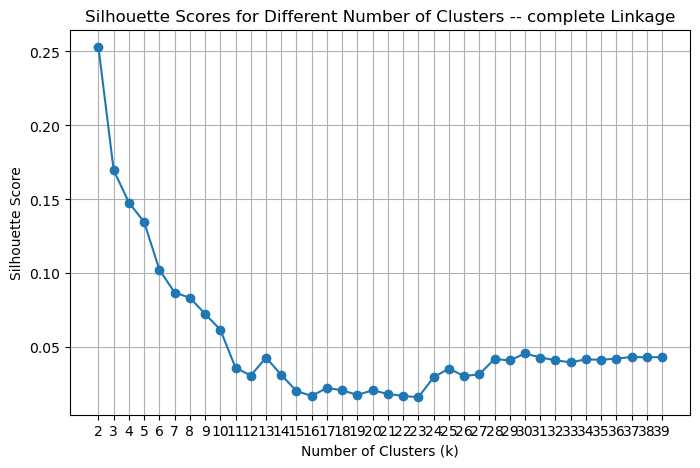

In [39]:
from sklearn.metrics import silhouette_score
linkage_methods = ['single', 'average', 'complete']

for link in linkage_methods:
    scores = []
    for k in range(2, 40):
        agg = AgglomerativeClustering(n_clusters=k, linkage=link, metric = 'precomputed')
        y_pred = agg.fit_predict(D)
        score = silhouette_score(D, y_pred)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2,40), scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Number of Clusters -- {link} Linkage')
    plt.xticks(range(2,40))
    plt.grid(True)
    plt.show()

In [41]:
baseline.loc['Agg_Single_21_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'single', k = 21, metric = 'precomputed')
baseline.loc['Agg_Avg_25_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'average', k = 25, metric = 'precomputed')
baseline.loc['Agg_Comp_2_corrdist'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'complete', k = 2, top = 15, metric = 'precomputed')
baseline

Linkage Method            : single
Preset Clusters           : 21
Sharpe Ratio of Portfolio : 0.0718
Silhouette Score          : -0.0749
Davies-Bouldin            : 0.6887
Calinski Harabasz         : 2.7114
Linkage Method            : average
Preset Clusters           : 25
Sharpe Ratio of Portfolio : 0.1185
Silhouette Score          : 0.0847
Davies-Bouldin            : 1.0936
Calinski Harabasz         : 12.0804
Linkage Method            : complete
Preset Clusters           : 2
Sharpe Ratio of Portfolio : 0.0521
Silhouette Score          : 0.2529
Davies-Bouldin            : 1.5239
Calinski Harabasz         : 109.7365


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255
Kmedoids_30_corrdist,0.105904,0.159607,0.244279
Kmedoids_27_corrdist,0.081372,0.122389,0.188329
Kmedoids_2_corrdist,0.122589,0.190844,0.264911


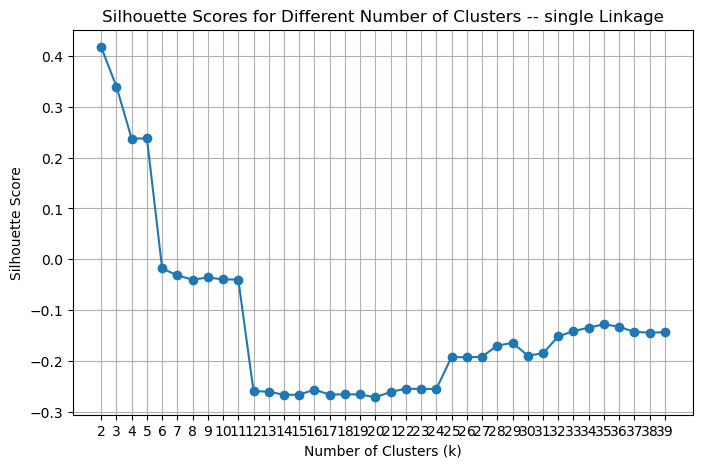

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  

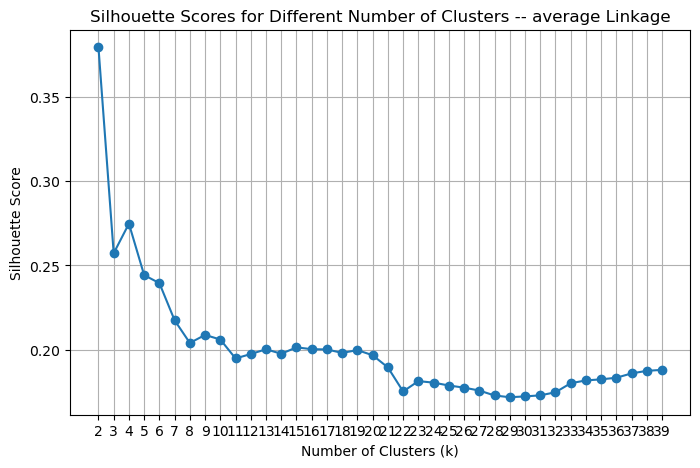

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  

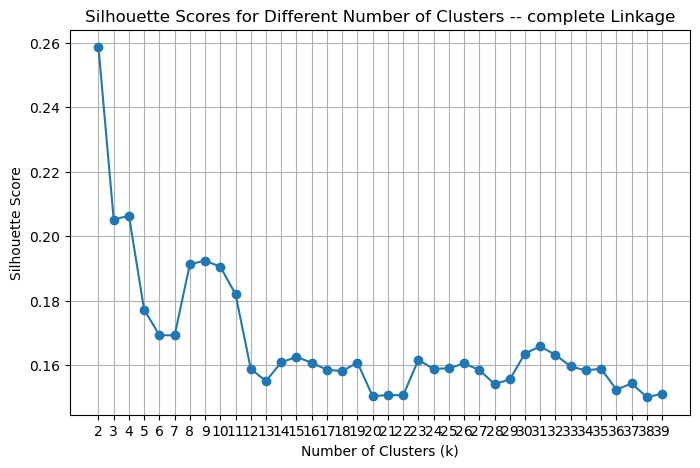

/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidea

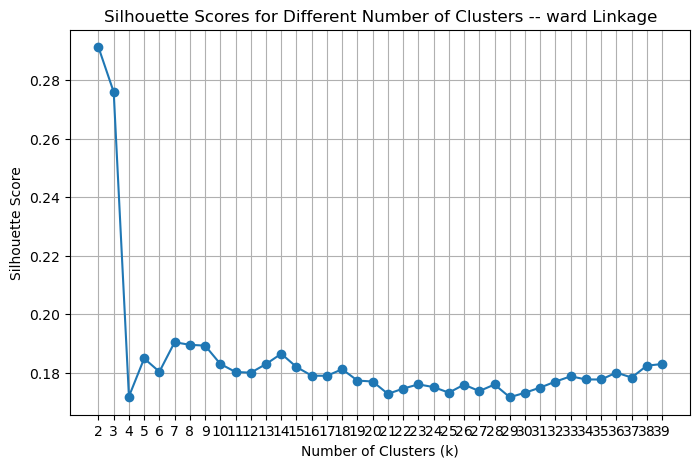

In [40]:
from sklearn.metrics import silhouette_score
linkage_methods = ['single', 'average', 'complete', 'ward']

for link in linkage_methods:
    scores = []
    for k in range(2, 40):
        agg = AgglomerativeClustering(n_clusters=k, linkage=link)
        y_pred = agg.fit_predict(D)
        score = silhouette_score(D, y_pred)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2,40), scores, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for Different Number of Clusters -- {link} Linkage')
    plt.xticks(range(2,40))
    plt.grid(True)
    plt.show()

In [43]:
baseline.loc['Agg_Single_34_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'single', k =35)
baseline.loc['Agg_Avg_19_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'average', k = 19)
baseline.loc['Agg_Comp_9_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'complete', k = 9, top = 3)
baseline.loc['Agg_Ward_14_corrdist_euc'] = agglomerative_cluster(D, sp500_train.stock_sharpe, sp500_test, method = 'ward', k = 14, top = 2)
baseline

Linkage Method            : single
Preset Clusters           : 35
Sharpe Ratio of Portfolio : 0.0638
Silhouette Score          : -0.1279
Davies-Bouldin            : 0.8676
Calinski Harabasz         : 8.5713


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Linkage Method            : average
Preset Clusters           : 19
Sharpe Ratio of Portfolio : 0.1182
Silhouette Score          : 0.1998
Davies-Bouldin            : 1.1990
Calinski Harabasz         : 70.0999


/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Linkage Method            : complete
Preset Clusters           : 9
Sharpe Ratio of Portfolio : 0.0879
Silhouette Score          : 0.1924
Davies-Bouldin            : 1.3806
Calinski Harabasz         : 107.5891


/opt/conda/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


Linkage Method            : ward
Preset Clusters           : 14
Sharpe Ratio of Portfolio : 0.0939
Silhouette Score          : 0.1865
Davies-Bouldin            : 1.4911
Calinski Harabasz         : 96.4096


,Sharpe,Sortino,Returns
DJI,0.071854,0.116324,0.137407
SP500,0.096611,0.150627,0.228182
Random,0.082695,0.131440,0.216654
Top30,0.122589,0.190844,0.264911
Kmeans_30_corrdist,0.117772,0.168851,0.265278
Kmeans_26_corrdist,0.132143,0.192891,0.302417
Kmeans_2_corrdist,0.099652,0.147505,0.218255
Kmedoids_30_corrdist,0.105904,0.159607,0.244279
Kmedoids_27_corrdist,0.081372,0.122389,0.188329
Kmedoids_2_corrdist,0.122589,0.190844,0.264911
